In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
# !pip install tensorflow-gpu == 1.13.1
# TensorFlow and tf.keras
# its just working with tensorflow 1.13.1, with others has problem
import tensorflow as tf
print(tf.__version__)

1.15.2


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls "/content/gdrive/My Drive/SignatureDetection"
root_path = '/content/gdrive/My Drive/SignatureDetection'

 0_Paper_CNN_Model.ipynb	     datasets
 Biometrics_SD_CNN_LSTM.ipynb	     General_SD_CNN_LSTM.ipynb
 CleanerCode_Paper_CNN_Model.ipynb   models
'Code Backup'			     SignatureDetectionPaper
 CVision_SD_CNN_LSTM.ipynb


In [ ]:
""" import the necessary packages """
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import backend as K
from sklearn.svm import SVC
import cv2
import glob
import pickle

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score 

""" tensorflow.keras imports """
from tensorflow.keras.layers import  Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, LSTM, Input, TimeDistributed, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras import optimizers

%matplotlib inline

""" Hyperparameters """
IMAGE_HEIGHT = 200
IMAGE_WIDTH = 320

TRAIN = True
ORIGINAL_PAPER = False
GET_DATA_AGAIN = False
CEDAR = True

if ORIGINAL_PAPER:
    print("INFO .... Original Paper Model")
    model_file = root_path + "/models/OriginalPaper_CNN_Model_1.h5"
    History_File = root_path + "/models/OriginalPaper_History_1.pkl"   
    EPOCHS = 20
    BS = 64 
else:
    print("INFO .... Our Model")
    model_file = root_path + "/models/My_CNN_Model_1.h5"
    History_File = root_path + "/models/My_History_1.pkl"
    EPOCHS = 40
    BS = 64

if CEDAR:
    file_pkl = root_path + '/datasets/DATA_IMG_CEDAR_1.pkl'
    pathGen = root_path + "/datasets/CEDAR/original/*/*.png"
    pathForg = root_path + "/datasets/CEDAR/forgeries/*/*.png"
else:
    file_pkl = root_path + '/datasets/DATA_IMG_UTSigDataset.pkl'
    pathGen = root_path + "/datasets/UTSigDataset/original/*/*.tif"
    pathForg = root_path + "/datasets/UTSigDataset/forgeries/*/*.tif"


INFO .... Our Model


In [ ]:
def DataPreparing(path):
    # reading addresses as a list like [DatasetSig1\original\user_1\original_1_1.png] """
    filenames = glob.glob(path) 

    """ reading all images as a grayscale images in 2D array format """
    imagesX = [cv2.imread(img,cv2.IMREAD_GRAYSCALE) for img in filenames] 

    """ usr_all contains all users name based on the folder addresses, we name folders like user1 ... user55 for 55
     user and we read our categories in format of original_user1 for user1's original signature """
    usr_all = []
    for file in filenames:
        _,_,_,_,_,_,_,_,imgY,_ = file.split("/")
        usr_all.append(imgY) 

    """ y_all contains all users signature images in gray Scale """
    X_all = []
    for img in imagesX:  
        img = 255 - img # invert the pixels signature pixels are around 200 in pixels
        img = cv2.resize(img,(IMAGE_WIDTH, IMAGE_HEIGHT)) # resize our images to be in same dimension for CNN        
        
        """ The function used is cv.threshold. First argument is the source image, which should be a grayscale image.
         Second argument is the threshold value which is used to classify the pixel values.
         Third argument is the maxVal which represents the value to be given if pixel value is
         more than (sometimes less than) the threshold value. """
        _, thresh1 = cv2.threshold(img,30,1,cv2.THRESH_BINARY) # return mask in binary format
        img = img * thresh1   

        img = cv2.fastNlMeansDenoising(img, None, 10, 7, 21)                
        
        """ add channel to img and makes it in 3D format to feed as tensor to convolution layers -> (width,height,1) """
        img = np.expand_dims(img, axis=2) 

        X_all.append(img) # (number of image, IMAGE_WIDTH, IMAGE_HEIGHT,1)

    usr_all = np.asarray(usr_all)
    X_all = np.asarray(X_all)        
    
    return X_all, usr_all

def getData(pathGen, pathForg):
    """ reading images and preparing them for training... """
    X_Gen , y_Gen =  DataPreparing(pathGen)
    X_Forg , y_Forg =  DataPreparing(pathForg)
    
    """ we concatenate images read from genuine and forgery folders """
    X_All = np.concatenate((X_Gen, X_Forg), axis=0) # All data
    usr_All = np.concatenate((y_Gen, y_Forg), axis=0) # category users
    
    """ category Genuine is 0 and Forgeries is 1 """
    Res_All = np.concatenate((np.zeros(len(y_Gen)), np.ones(len(y_Forg))), axis=0) 
    
    return X_All, usr_All, Res_All

""" function to save data as pkl format to speed up the process of loading data as image every time."""
def save_pkl_imgs(file_pkl, X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB):
    DATA_IMG = {}    
    DATA_IMG["X_All"] = X_All
    DATA_IMG["m_usr_All"] = m_usr_All
    DATA_IMG["Res_All"] = Res_All
    DATA_IMG["X_Train"] = X_Train
    DATA_IMG["m_usr_Train"] = m_usr_Train
    DATA_IMG["Res_Train"] = Res_Train
    DATA_IMG["X_Test"] = X_Test
    DATA_IMG["m_usr_Test"] = m_usr_Test
    DATA_IMG["Res_Test"] = Res_Test
    DATA_IMG["usrLabelBinarizer"] = usrLabelBinarizer
    DATA_IMG["usr_Train_LB"] = usr_Train_LB
    DATA_IMG["usr_Test_LB"] = usr_Test_LB

    with open(file_pkl, "wb") as outfile: 
        pickle.dump(DATA_IMG, outfile)

""" load pkl file of data """
def load_pkl_imgs(file_pkl):
    DATA_IMG = pickle.load(open(file_pkl, "rb"))
    X_All = DATA_IMG["X_All"]
    m_usr_All = DATA_IMG["m_usr_All"]
    Res_All = DATA_IMG["Res_All"] 
    X_Train = DATA_IMG["X_Train"]
    m_usr_Train = DATA_IMG["m_usr_Train"]
    Res_Train = DATA_IMG["Res_Train"] 
    X_Test = DATA_IMG["X_Test"] 
    m_usr_Test = DATA_IMG["m_usr_Test"] 
    Res_Test = DATA_IMG["Res_Test"] 
    usrLabelBinarizer = DATA_IMG["usrLabelBinarizer"] 
    usr_Train_LB = DATA_IMG["usr_Train_LB"] 
    usr_Test_LB = DATA_IMG["usr_Test_LB"] 
    
    return X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB

In [ ]:
def PrepareDataForTrain(GET_DATA_AGAIN = False):
    # Load Data From PKL or From Scratch
    if GET_DATA_AGAIN == True:
        print("[INFO] Getting Data ...")
        X_All, m_usr_All, Res_All = getData(pathGen, pathForg)

        print("[INFO] Train Test Split with 25% for Test ...")
        from sklearn.model_selection import train_test_split
        X_Train, X_Test, m_usr_Train, m_usr_Test, Res_Train, Res_Test = train_test_split(X_All, m_usr_All, Res_All, test_size=0.25, random_state=42, stratify = m_usr_All)

        usrLabelBinarizer = LabelBinarizer()
        usrLabelBinarizer.fit(m_usr_Train)
        usr_Train_LB = usrLabelBinarizer.transform(m_usr_Train)
        usr_Test_LB = usrLabelBinarizer.transform(m_usr_Test)
        print(usr_Train_LB[0])
        print(m_usr_Train[0])
        print(usrLabelBinarizer.classes_)

        print("[INFO] Save Data in PKL Format ...")
        save_pkl_imgs(file_pkl, X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB)
    else:
        print("[INFO] Load Data from PKL Format ...")
        X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB = load_pkl_imgs(file_pkl)


    print(X_Train.shape)
    print(m_usr_Train.shape)
    print(Res_Train.shape)
    print(X_Test.shape)
    print(m_usr_Test.shape)
    print(Res_Test.shape)

    print(m_usr_Train[:30])
    print(Res_Train[:30])
    print(m_usr_Test[:30])
    print(Res_Test[:30])

    return X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB


def plot_images1(images, usr_true, Res_true):
    img_shape = (IMAGE_HEIGHT, IMAGE_WIDTH)
    assert len(images) == len(usr_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(9,9))    
    fig.subplots_adjust(hspace=0, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.        
        xlabel = "user : {0} , Res : {1}".format(usr_true[i], Res_true[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots in a single Notebook cell.
    plt.show()

In [ ]:
# train_number = 0
# test_number = 0
# for i in m_usr_Train:
#     if i == 'user_01':
#         train_number+=1

# for i in m_usr_Test:
#     if i == 'user_01':
#         test_number+=1        

# print("train_number = ", train_number)        
# print("test_number = ", test_number)        

In [ ]:
""" ///////////////////////////// Build CNN ///////////////////////////////////////////////// """
def build_model(inputs, NumOfUser):
    x = Conv2D(96, (11,11), strides=4, padding= 'valid', activation='relu', kernel_regularizer = regularizers.l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = Conv2D(256, (5,5), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Conv2D(384, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = Conv2D(256, (3,3), strides=1, padding= 'same', activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((3,3), strides=2, padding='same')(x)
    x = Flatten()(x)

    if ORIGINAL_PAPER:
        x = Dense(units = 2048 , activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(units = 2048, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
    else:
        x = Dense(units = 2048 , activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dense(units = 1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)
        x = Dropout(0.5)(x)
        x = Dense(units = 256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
        x = BatchNormalization()(x)

    x = Dropout(0.3)(x)
    user_Model = Dense(units = NumOfUser,  kernel_regularizer=regularizers.l2(0.01))(x)
    Res_Model = Dense(units = 1,  kernel_regularizer=regularizers.l2(0.01))(x)
    user_Model = Activation("softmax", name = "User")(user_Model)
    Res_Model = Activation("sigmoid", name = "Res")(Res_Model)
    return user_Model, Res_Model

def train(width, height, X_Train, usr_Train_LB, Res_Train, X_Test, usr_Test_LB, Res_Test):
    """ initialize our multi-output network, softmax for users because they are many and sigmoid
     for genuine(0) or forgery(1) becuase its binary """
    inputShape = (height, width, 1)
    inputs = Input(shape = inputShape)
    NumOfUser = len(usr_Train_LB[0])
    User, Res = build_model(inputs, NumOfUser)
    model = Model(inputs = inputs, outputs = [User, Res], name = "SigNet")  

    """ we are going to use this H list for storing history returned by our model for plot porpuses. """  
    y_pred, H = [], []

    """ we defined two dictionaries: one that specifies the loss method for each output of the network
     along with a second dictionary that specifies the weight per loss """
    losses = { "User": "categorical_crossentropy", "Res": "binary_crossentropy"}

    """ it's Hyperparameter Lambda that we use for trade-off between 2 loss function as used in paper """  
    LamdaWeight = 0.7
    lr = 0.0001
    lossWeights = {"User": 1-LamdaWeight, "Res": LamdaWeight}     

    """ its a loop for training with different learning rates. """
    for i in range(7):
        """ initialize the optimizer and compile the model """
        print("[INFO] compiling model... in iteration", i+1)
        opt = SGD(lr=lr, momentum=0.9, decay=1e-4, nesterov=False)
        lr = lr/10
        h=[]
            
        """ train the network to perform multi-class classification """
        model.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, metrics=["acc"])     

        """ model training """
        h = model.fit(X_Train, {"User": usr_Train_LB, "Res": Res_Train}, validation_data = (X_Test, {"User": usr_Test_LB, "Res": Res_Test}),
                    epochs = EPOCHS, batch_size = BS, verbose=1)
        
        y_pred = model.predict(X_Train)[1][:] >= 0.5 # Genuine or forgery result based on threshold of 0.5

        lossWeights = {"User": (1-LamdaWeight) * y_pred, "Res": LamdaWeight}
        
        H.append(h)    

    return model, H

""" Save model """
def save_CNN_model(model, file):
    from keras.models import save_model
    save_model(model, file)
    print("INFO .... Model Saved ..... ")

""" load model """
def load_CNN_model(file):
    from keras.models import load_model
    model = load_model(file)
    print("INFO .... Model Loaded .... ")
    return model

""" function to save History as pkl format to speed up the process of loading."""
def save_pkl_History(H, file):
    DATA_IMG = {}    
    DATA_IMG["History"] = H
    with open(file, "wb") as outfile: 
        pickle.dump(DATA_IMG, outfile)

""" load pkl file of History """
def load_pkl_History(file):
    DATA_IMG = pickle.load(open(file, "rb"))
    H = DATA_IMG["History"]        
    return H        

[INFO] Load Data from PKL Format ...
(1980, 200, 320, 1)
(1980,)
(1980,)
(660, 200, 320, 1)
(660,)
(660,)
['user_41' 'user_20' 'user_17' 'user_14' 'user_49' 'user_03' 'user_37'
 'user_45' 'user_16' 'user_41' 'user_18' 'user_39' 'user_31' 'user_29'
 'user_35' 'user_21' 'user_32' 'user_02' 'user_16' 'user_33' 'user_04'
 'user_39' 'user_16' 'user_51' 'user_12' 'user_23' 'user_05' 'user_46'
 'user_42' 'user_39']
[1. 1. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0.
 1. 0. 1. 1. 1. 1.]
['user_19' 'user_39' 'user_22' 'user_04' 'user_39' 'user_09' 'user_21'
 'user_34' 'user_50' 'user_20' 'user_30' 'user_06' 'user_48' 'user_47'
 'user_15' 'user_03' 'user_14' 'user_24' 'user_43' 'user_04' 'user_53'
 'user_30' 'user_31' 'user_15' 'user_45' 'user_52' 'user_19' 'user_26'
 'user_13' 'user_32']
[0. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 1. 0.
 0. 0. 1. 0. 0. 1.]


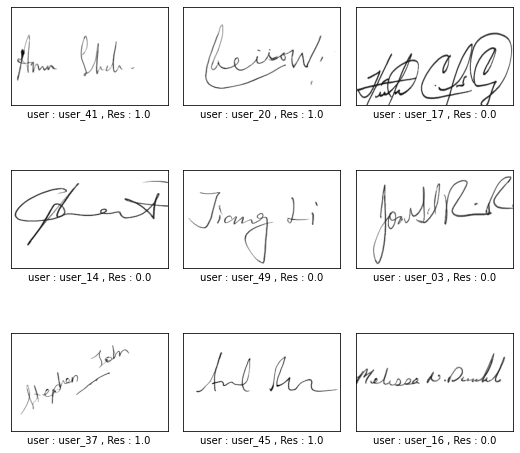

[INFO] compiling model... in iteration 1
Train on 1980 samples, validate on 660 samples
Epoch 1/40
1980/1980 [==============================] - 7s 4ms/sample - loss: 68.3562 - User_loss: 5.0683 - Res_loss: 0.9301 - User_acc: 0.0182 - Res_acc: 0.5258 - val_loss: 67.9008 - val_User_loss: 4.2500 - val_Res_loss: 0.6852 - val_User_acc: 0.0136 - val_Res_acc: 0.5955
Epoch 2/40
1980/1980 [==============================] - 5s 3ms/sample - loss: 68.1275 - User_loss: 4.9236 - Res_loss: 0.7701 - User_acc: 0.0222 - Res_acc: 0.6152 - val_loss: 67.7214 - val_User_loss: 4.0423 - val_Res_loss: 0.6243 - val_User_acc: 0.0242 - val_Res_acc: 0.6879
Epoch 3/40
1980/1980 [==============================] - 5s 3ms/sample - loss: 67.9632 - User_loss: 4.7309 - Res_loss: 0.7325 - User_acc: 0.0354 - Res_acc: 0.6374 - val_loss: 67.5876 - val_User_loss: 3.9845 - val_Res_loss: 0.5836 - val_User_acc: 0.0439 - val_Res_acc: 0.7030
Epoch 4/40
1980/1980 [==============================] - 5s 3ms/sample - loss: 67.8132 - Us

In [ ]:
# Get Data
X_All, m_usr_All, Res_All, X_Train, m_usr_Train, Res_Train, X_Test, m_usr_Test, Res_Test, usrLabelBinarizer, usr_Train_LB, usr_Test_LB = PrepareDataForTrain(GET_DATA_AGAIN)

plot_images1(X_Train[:9], m_usr_Train[:9], Res_Train[:9])

if TRAIN:
    if ORIGINAL_PAPER: 
        print("INFO .... original paper model training .... ")
    model, H = train(IMAGE_WIDTH, IMAGE_HEIGHT, X_Train, usr_Train_LB, Res_Train, X_Test, usr_Test_LB, Res_Test)
    save_CNN_model(model, model_file)
    save_pkl_History(H, History_File)
else:
    if ORIGINAL_PAPER: 
        print("INFO .... original paper model training .... ")
    model = load_CNN_model(model_file)
    H = load_pkl_History(History_File)

""" summarize model """
model.summary()

""" accuracy of model """
print(model.evaluate(X_Test, {"User": usr_Test_LB, "Res": Res_Test})[-2:]) # just to get accuracy of User and Res   

In [ ]:
def PlotHistoryCallBack(H):
    """ set the matplotlib backend so figures can be saved in the background """
    trained_model = np.array(H)

    lossNames = ["loss", "User_loss", "Res_loss"]
    accuracyNames = ["User_acc", "Res_acc"]

    losses_all_iterations, accuracy_all_iterations, val_losses_all_iterations, val_accuracy_all_iterations = [],[],[],[]

    for loss in lossNames:
        losses_all_iterations.append([])
        val_losses_all_iterations.append([])
        
    for accuracy in accuracyNames:
        accuracy_all_iterations.append([])
        val_accuracy_all_iterations.append([])
            
    for i, loss in enumerate(lossNames):
        for single_model in trained_model:
            if loss == "loss":
                # because returned valued of loss in case of total loss is evaluated for each signature and returned in list
                # format for each single signature in keras callback we have to handle it by taking mean by ourself
                a_train = []
                a_val = []
                for lloss in single_model.history[loss]: 
                    a_train.append(np.mean(lloss))
                    
                for lloss in single_model.history['val_' + loss]: 
                    a_val.append(np.mean(lloss))   
                    
                losses_all_iterations[i].append(a_train)
                val_losses_all_iterations[i].append(a_val)
            else:
                # in case of user and Res we have just one loss for each epoch so dont need to take mean.            
                losses_all_iterations[i].append(single_model.history[loss])
                val_losses_all_iterations[i].append(single_model.history['val_' + loss])

        
    for i, accuracy in enumerate(accuracyNames):
        for single_model in trained_model:
            accuracy_all_iterations[i].append(single_model.history[accuracy])  
            val_accuracy_all_iterations[i].append(single_model.history['val_' + accuracy])
            
            
    losses_all_iterations = np.asarray(losses_all_iterations)
    accuracy_all_iterations = np.asarray(accuracy_all_iterations)

    val_losses_all_iterations = np.asarray(val_losses_all_iterations)
    val_accuracy_all_iterations = np.asarray(val_accuracy_all_iterations)

    # set the matplotlib backend so figures can be saved in the background
    import matplotlib
    # matplotlib.use("Agg")
    # plot the losses
    lossNames = ["loss", "User_loss", "Res_loss"]
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(3, 1, figsize=(13, 13))
    
    for (i, loss) in enumerate(lossNames):
        # plot the loss for both the training and validation data
        title = "Loss for {}".format(loss) if loss != "loss" else "Total loss"
        ax[i].set_title(title)
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel("Loss")
        ax[i].plot(losses_all_iterations[i].flatten(), label=loss)
        ax[i].plot(val_losses_all_iterations[i].flatten(),
            label="val_" + loss)
        ax[i].legend()
    
    plt.tight_layout()
    plt.show()
    plt.close()

    print("\n")


    # plot figure for accuracy
    accuracyNames = ["User_acc", "Res_acc"]
    plt.style.use("ggplot")
    (fig, ax) = plt.subplots(2, 1, figsize=(8, 8))
    
    for (i, acc) in enumerate(accuracyNames):
        # plot the loss for both the training and validation data
        ax[i].set_title("Accuracy for {}".format(acc))
        ax[i].set_xlabel("Epoch #")
        ax[i].set_ylabel("Accuracy")
        ax[i].plot(accuracy_all_iterations[i].flatten(), label=acc)
        ax[i].plot(val_accuracy_all_iterations[i].flatten(),
            label="val_" + acc)
        ax[i].legend()
    
    # save the accuracies figure
    plt.tight_layout()
    plt.show()
    plt.close()


""" Code is from Scikit-learn website """
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        # print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


In [ ]:
PlotHistoryCallBack(H)

NameError: ignored

In [ ]:
def predict(model, x_data, threshold):
    """ User prediction section based on argmax """
    pred = model.predict(x_data)
    usr_pred = np.argmax(pred[0][:], axis = 1)
    usrClasses = usrLabelBinarizer.classes_
    pred_usr = []
    
    for i in range(len(usr_pred)):
        pred_usr.append(usrClasses[usr_pred[i]])

    """ Genuine or Forgery Prediction as Result """
    Res_pred = []
    for i in range(len(pred[1])):
        Res_pred.append(1 if pred[1][i] >= threshold else 0)

    return pred_usr, Res_pred
    

[Confusion Matrix in Machine Learning with EXAMPLE
](https://www.guru99.com/confusion-matrix-machine-learning-example.html)

1.   FAR: False Acceptance Rate - FAR = FPR = FP/(FP+TN)
1.   FRR: False Rejection Rate - FRR = FNR = FN/(TP+FN)
2.   ERR: Equal Error Rate - 
1.   DET: Detection Error Trade-off
2.   ROC: Receiving Operating Curve


   We have a signature system. In order to evaluate a performance of any biometric system, we need to gather a database. our  database consists of 55 legitimate users (USER_1-USER_55) and each user provided his finger 24 times (55x24 = 1320 Genuine images in total) also we have 24 forgery image for each user too (55x24 = 1320 Genuine images in total), so our total images is 2640.

   Lets assume, that single image is sufficient for template creation. You select a user (e. g. USER_1) and one his signature image and create the template. The rest of his images you use to verify the signature and you receive 23 genuine scores. All images of other users you use as a impostors and you receive 54*24 impostor scores. You repeat the template generation for all images and all users and in total you receive 55*23 genuine scores and 55*55*23 impostor scores. These scores are usually used to generate so called ROC curves to choose the best threshold suiting your problem. If you have chosen a threshold, you can calculate the FAR and FRR using the definition I stated above.


[How can I calculate the Failed Acceptance Rate and False Recognition Rate?](https://www.researchgate.net/post/How_to_find_FRR_and_FAR_for_biometric_identification_using_retina)

In [ ]:
thresholds = np.arange(start=0, stop=1.01, step=0.1)
EER_Res, FAR_Res, FRR_Res = [],[],[]

for threshold in thresholds:
    usr_pred, Res_pred = predict(model, X_Test, threshold)
    print("accuracy of Res : ", accuracy_score(Res_Test, Res_pred, normalize=True) )
    print("accuracy of User : ", accuracy_score(m_usr_Test, usr_pred, normalize=True) )
    classesRes = [0,1]
    cnf_matrix_Res = confusion_matrix(Res_Test, Res_pred)   
    
    TN_Res = cnf_matrix_Res[0][0]
    TP_Res = cnf_matrix_Res[1][1]
    FP_Res = cnf_matrix_Res[0][1]
    FN_Res = cnf_matrix_Res[1][0]

    FAR = FP_Res / (FP_Res + TN_Res)
    FRR = FN_Res / (TP_Res + FN_Res)
    EER = (FRR + FAR)/2
    # EER or AER is AER = (FRR + FARrandom + FARsimple + FARskilled)/4. in our case just = (FRR + FARskilled)/2

    print("FAR = ", FAR, "With Threshold of: ", threshold)
    print("FRR = ", FRR, "With Threshold of: ", threshold)
    print("EER = ", EER, "With Threshold of: ", threshold)
    FAR_Res.append(FAR)
    FRR_Res.append(FRR)
    EER_Res.append(EER)
    plt.figure()
    plot_confusion_matrix(cnf_matrix_Res, classes=classesRes, normalize=True, title='confusion matrix')
    plt.show()
    plt.tight_layout()  
    plt.close()  
    print("============================================================ \n")
    

We evaluate the performance on the testing set using the following metrics: False Rejection Rate (FRR): the fraction of genuine signatures rejected as forgeries; False Acceptance Rate (FARrandom and FARskilled): the fraction of forgeries accepted as genuine (considering random forgeries and skilled forgeries). We also report the Equal Error Rate (EER): which is the error when FAR = FRR.We considered two forms of calculating the EER: EERuser thresholds: using user-specific decision thresholds; and EERglobal threshold: using a global decision threshold. In both cases, to calculate the Equal Error Rate we only considered skilled forgeries (not random forgeries) - that is, we use only FRR and FARskilled to estimate the optimum threshold and report the Equal Error Rate. We also report the mean Area Under the Curve (AUC), considering ROC curves created for each user individually. For calculating FAR and FRR in the GPDS exploitation set, we used a decision threshold selected from the validation set Vv (the threshold that achieved EER using a global decision threshold). For the Brazilian PUC-PR dataset, we followed the convention of previous research in this
dataset, and also report the individual errors (False Rejection Rate and False Acceptance Rate for different types of forgery) and the Average error rate, calculate as AER = (FRR + FARrandom + FARsimple + FARskilled)/4. Since in this work we are mostly interested in the problem of distinguishing genuine signatures and skilled forgeries, we also report AERgenuine + skilled = (FRR + FARskilled)/2.

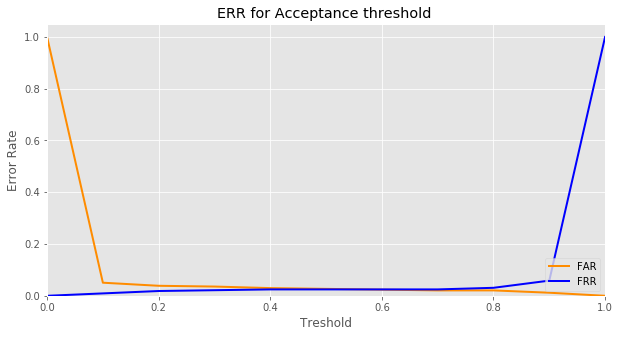

In [ ]:
""" curve for best ERR """
plt.figure(figsize=(10,5))
plt.plot(thresholds, FAR_Res, color='darkorange', lw=2, label='FAR')
plt.plot(thresholds, FRR_Res, color='blue', lw=2, label='FRR')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Treshold')
plt.ylabel('Error Rate')
plt.title('ERR for Acceptance threshold ')
plt.legend(loc="lower right")
plt.show()


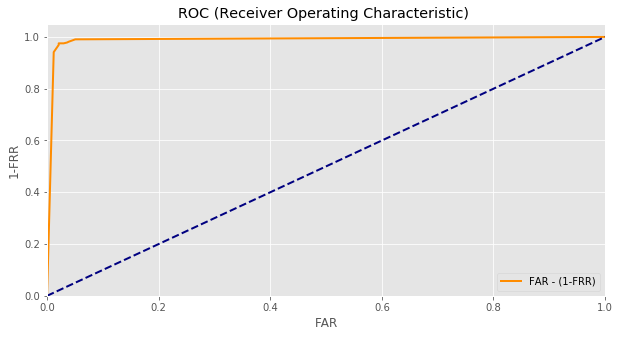

In [ ]:
""" ROC (Receiver Operating Characteristic) """
plt.figure(figsize=(10,5))
plt.plot(FAR_Res, np.ones(shape= len(FRR_Res))-FRR_Res, color='darkorange', lw=2, label='FAR - (1-FRR)')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FAR')
plt.ylabel('1-FRR')
plt.title('ROC (Receiver Operating Characteristic) ')
plt.legend(loc="lower right")
plt.show()


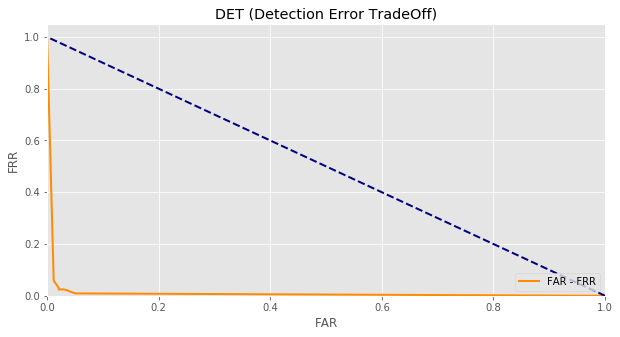

In [ ]:
""" DET (Detection Error TradeOff) """
plt.figure(figsize=(10,5))
plt.plot(FAR_Res, FRR_Res, color='darkorange', lw=2, label='FAR - FRR')
plt.plot([1, 0], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.title('DET (Detection Error TradeOff)')
plt.legend(loc="lower right")
plt.show()

In [ ]:
""" Confusion matrix for Users """
classesUser = usrLabelBinarizer.classes_
cnf_matrix_usr = confusion_matrix(m_usr_Test, usr_pred) 
TN_usr, TP_usr, FP_usr, FN_usr = [],[],[],[]

for i in range(len(classesUser)):
    TN_tmp, TP_tmp, FP_tmp, FN_tmp = 0,0,0,0
    for j in range(len(cnf_matrix_usr)):
        for k in range(len(cnf_matrix_usr)):                           
            if (k == j) and (k != i):
                TN_tmp += cnf_matrix_usr[k][j]                
            if (k == j) and (k == i):    
                TP_tmp += cnf_matrix_usr[k][j]                
            if (k != j) and (j != i) and (j == i):
                FP_tmp += cnf_matrix_usr[k][j]
            if (k != j) and (k == i):                 
                FN_tmp += cnf_matrix_usr[k][j]
    
    TN_usr.append(TN_tmp)
    TP_usr.append(TP_tmp)
    FP_usr.append(FP_tmp)
    FN_usr.append(FN_tmp)                

TN_usr = np.asarray(TN_usr)
TP_usr = np.asarray(TP_usr)
FP_usr = np.asarray(FP_usr)
FN_usr = np.asarray(FN_usr)

print("\n")
print("TN_usr = ", sum(TN_usr))
print("TP_usr = ", sum(TP_usr))
print("FP_usr = ", sum(FP_usr))
print("FN_usr = ", sum(FN_usr))

FAR_usr = FP_usr / (FP_usr + TN_usr)
FRR_usr = FN_usr / (TP_usr + FN_usr)
print("FAR_usr = ", FAR_usr)
print("FRR_usr = ", FRR_usr)

plt.figure(figsize=(15,15))
plot_confusion_matrix(cnf_matrix_usr, classes=classesUser, normalize=False, title='confusion matrix')
plt.show()
plt.close()



TN_usr =  35532
TP_usr =  658
FP_usr =  0
FN_usr =  2
FAR_usr =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0.]
FRR_usr =  [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.08333333 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.08333333
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.        ]
Confusion matrix, without normalization


In [ ]:
""" ///////////////////////// get the nth Layer of CNN /////////////////////////////////////////////// """
def getFeatures(clf , Data, n):
        get_nth_layer_output = K.function([clf.layers[0].input],
                                  [clf.layers[n].output])
        FeatureLayer = get_nth_layer_output([Data])[0]
        FeatureLayer = np.asarray(FeatureLayer)
        return FeatureLayer

""" function to save Features as pkl format to speed up the process of loading."""
def save_pkl_Features(TrainFeature, TestFeature, file):
    DATA_IMG = {}    
    DATA_IMG["TrainFeature"] = TrainFeature
    DATA_IMG["TestFeature"] = TestFeature
    with open(file, "wb") as outfile: 
        pickle.dump(DATA_IMG, outfile)

""" load pkl file of Features """
def load_pkl_Features(file):
    DATA_IMG = pickle.load(open(file, "rb"))
    TrainFeature = DATA_IMG["TrainFeature"]
    TestFeature = DATA_IMG["TestFeature"]        
    return TrainFeature, TestFeature       

""" Save model """
def save_KERAS_model(model, file):
    from keras.models import save_model
    save_model(model, file)

""" load model """
def load_KERAS_model(file):
    from keras.models import load_model
    model = load_model(file)
    return model

In [ ]:
GET_FEATURES = False
Features_file = root_path + "/models/LSTM_TrainTestFeatures.pkl"

if GET_FEATURES:
    """ getting features from last fully connected layer of CNN model"""
    TrainFeature = getFeatures(model, X_Train, -5)
    TestFeature = getFeatures(model, X_Test, -5)
    save_pkl_Features(TrainFeature, TestFeature, Features_file)
else:
    TrainFeature, TestFeature = load_pkl_Features(Features_file)

print(TrainFeature.shape)
print(TestFeature.shape)

(1980, 256)
(660, 256)


In [ ]:
def train(max_features):
    lr = 0.1; EPOCHS = 50; BS = 64; LamdaWeight = 0.7; dropout = 0.5

    inputs = Input(shape=(max_features,))
    x = Embedding(input_dim= max_features, output_dim=128)(inputs)

    x = LSTM(units = 128, dropout=dropout, return_sequences=True)(x)
    x = LSTM(units = 128, dropout=dropout, return_sequences=True)(x)
    x = LSTM(units = 128, dropout=dropout, return_sequences=False)(x)

    User = Dense(units = len(usr_Train_LB[0]))(x)
    Res = Dense(units = 1)(x)
    User = Activation("softmax", name = "User")(User)
    Res = Activation("sigmoid", name = "Res")(Res)
    
    modelLSTM = Model(inputs = inputs, output = [User, Res] , name = "SigNet") 
    losses = { "User": "categorical_crossentropy", "Res": "binary_crossentropy"}

    lossWeights = {"User": 1-LamdaWeight, "Res": LamdaWeight}     

    """ its a loop for training with different learning rates. """
    for i in range(3):
        print("[INFO] compiling modelLSTM... in iteration", i+1)
        opt = SGD(lr=lr, momentum=0.9, decay=1e-4, nesterov=False)
        lr = lr/10
            
        modelLSTM.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, metrics=["accuracy"])     

        modelLSTM.fit(TrainFeature, {"User": usr_Train_LB, "Res": Res_Train}, 
                      validation_data = (TestFeature, {"User": usr_Test_LB, "Res": Res_Test}),
                      epochs = EPOCHS, batch_size = BS, verbose=1)

    return modelLSTM


In [ ]:
modelLSTM = train(len(TrainFeature[0]))
modelLSTM_file = root_path + "/models/modelLSTM.h5"
save_KERAS_model(modelLSTM, modelLSTM_file )
score = modelLSTM.evaluate(TestFeature, {"User": usr_Test_LB, "Res": Res_Test}, batch_size=64)[-2:]
print(score)

660/660 [==============================] - 5s 8ms/step
[0.8257575753963355, 0.896969696969697]


In [ ]:
from keras.layers import GRU, Bidirectional, concatenate, LSTM
def train(max_features):
    lr = 0.1; EPOCHS = 50; BS = 64; units = 128; LamdaWeight = 0.7; dropout = 0.5

    inputs = Input(shape=(max_features,))
    x = Embedding(input_dim= max_features, output_dim=128)(inputs)

    forw = GRU(units= units, return_sequences=True, dropout= dropout)(x)
    forw = GRU(units= units, dropout= dropout)(forw)
    back = GRU(units= units, return_sequences=True, go_backwards=True, dropout= dropout)(x)
    back = GRU(units= units, go_backwards=True, dropout= dropout)(back)
    BDLSTM1 = concatenate([forw, back], axis = -1)

    forw = GRU(units= units, return_sequences=True, dropout= dropout)(x)
    forw = GRU(units= units, dropout= dropout)(forw)
    back = GRU(units= units, return_sequences=True, go_backwards=True, dropout= dropout)(x)
    back = GRU(units= units, go_backwards=True, dropout= dropout)(back)
    BDLSTM2 = concatenate([forw, back], axis = -1)

    output = concatenate([BDLSTM1, BDLSTM2], axis = -1)
    User = Dense(units = len(usr_Train_LB[0]))(output)
    Res = Dense(units = 1)(output)
    User = Activation("softmax", name = "User")(User)
    Res = Activation("sigmoid", name = "Res")(Res)
    
    modelGRU = Model(inputs = inputs, output = [User, Res] , name = "SigNet") 
    losses = { "User": "categorical_crossentropy", "Res": "binary_crossentropy"}
    lossWeights = {"User": 1-LamdaWeight, "Res": LamdaWeight}     

    for i in range(3):
        print("[INFO] compiling modelGRU... in iteration", i+1)
        opt = SGD(lr=lr, momentum=0.9, decay=1e-4, nesterov=False)
        lr = lr/10
        modelGRU.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, metrics=["accuracy"]) 
        """ model training """
        modelGRU.fit(TrainFeature, {"User": usr_Train_LB, "Res": Res_Train},
                     validation_data = (TestFeature, {"User": usr_Test_LB, "Res": Res_Test}),
                     epochs = EPOCHS, batch_size = BS, verbose=1)

    return modelGRU

In [ ]:
modelGRU = train(len(TrainFeature[0]))
modelGRU_file = root_path + "/models/modelGRU.h5"
save_KERAS_model(modelGRU, modelGRU_file )
modelGRU = load_KERAS_model(modelGRU_file)
score = modelGRU.evaluate(TestFeature, {"User": usr_Test_LB, "Res": Res_Test}, batch_size=64)[-2:]
print(score)

660/660 [==============================] - 12s 18ms/step
[0.8424242424242424, 0.9212121208508809]


In [ ]:
from keras.layers import LSTM, Bidirectional, concatenate
def train(max_features):
    lr = 0.1; EPOCHS = 50; BS = 64; units = 128; LamdaWeight = 0.5; dropout = 0.5

    inputs = Input(shape=(max_features,))
    x = Embedding(input_dim= max_features, output_dim=128)(inputs)

    forw = LSTM(units= units, return_sequences=True, dropout= dropout)(x)
    forw = LSTM(units= units, dropout= dropout)(forw)
    back = LSTM(units= units, return_sequences=True, go_backwards=True, dropout= dropout)(x)
    back = LSTM(units= units, go_backwards=True, dropout= dropout)(back)
    
    BDLSTM1 = concatenate([forw, back], axis = -1)

    forw = LSTM(units= units, return_sequences=True, dropout= dropout)(x)
    forw = LSTM(units= units, dropout= dropout)(forw)
    back = LSTM(units= units, return_sequences=True, go_backwards=True, dropout= dropout)(x)
    back = LSTM(units= units, go_backwards=True, dropout= dropout)(back)
    BDLSTM2 = concatenate([forw, back], axis = -1)

    output = concatenate([BDLSTM1, BDLSTM2], axis = -1)
    User = Dense(units = len(usr_Train_LB[0]))(output)
    Res = Dense(units = 1)(output)
    User = Activation("softmax", name = "User")(User)
    Res = Activation("sigmoid", name = "Res")(Res)
    
    modelBDLSTM = Model(inputs = inputs, output = [User, Res] , name = "SigNet") 

    losses = { "User": "categorical_crossentropy", "Res": "binary_crossentropy"}
    lossWeights = {"User": 1-LamdaWeight, "Res": LamdaWeight}     

    print("[INFO] compiling modelBDLSTM... ")
    opt = SGD(lr=lr, momentum=0.9, decay=1e-4, nesterov=False)
        
    modelBDLSTM.compile(optimizer = opt, loss = losses, loss_weights = lossWeights, metrics=["accuracy"])     

    modelBDLSTM.fit(TrainFeature, {"User": usr_Train_LB, "Res": Res_Train},
                    validation_data = (TestFeature, {"User": usr_Test_LB, "Res": Res_Test}),
                    epochs = EPOCHS, batch_size = BS, verbose=1)
    
    return modelBDLSTM
    

In [ ]:
modelBDLSTM = train(len(TrainFeature[0]))
modelBDLSTM_file = root_path + "/models/modelBDLSTM.h5"
save_KERAS_model(modelBDLSTM, modelBDLSTM_file )
modelBDLSTM = load_KERAS_model(modelBDLSTM_file)
score = modelBDLSTM.evaluate(TestFeature, {"User": usr_Test_LB, "Res": Res_Test}, batch_size=64)[-2:]
print(score)

660/660 [==============================] - 14s 21ms/step
[0.8757575757575757, 0.9106060606060606]


In [ ]:
img_shape = (200,320)
def plot_images(images, cls_true, cls_pred=None):
    # assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3, figsize=(9,9))    
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.        
        xlabel = "Tr: {0}, Pr: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

    

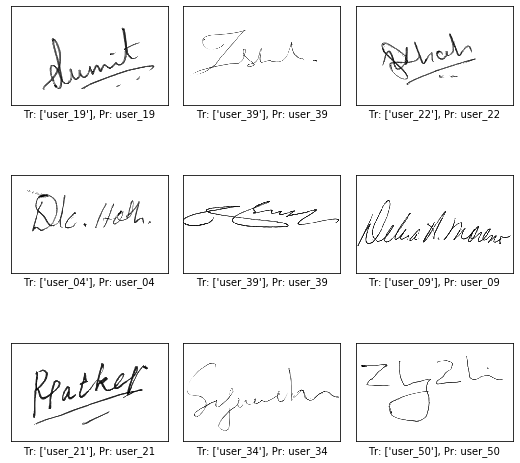

In [ ]:
threshold = 0.5
usr_Test_C, usr_pred, Res_pred = predict(model, X_Test, usr_Test, threshold)    
    
# Get the first images from the test-set.
images = X_Test[0:9]

# Get the true classes for those images.
cls_true = usr_Test_C[0:9]

cls_pred = usr_pred[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)    

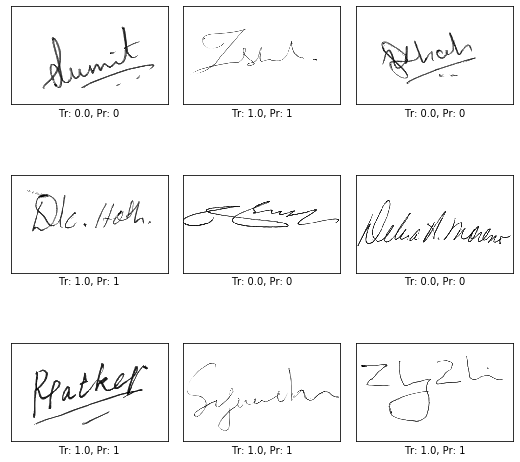

In [ ]:
# Get the true classes for those images.
cls_true = Res_Test[0:9]

cls_pred = Res_pred[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)  

In [ ]:
Res_mistakes_Truth = []
Res_mistakes_pred = []
User_mistakes_Truth = []
User_mistakes_pred = []
for i in range(len(Res_Test)):
    if Res_Test[i] != Res_pred[i]:
        Res_mistakes_Truth.append(int(Res_Test[i]))
        Res_mistakes_pred.append(Res_pred[i])
    if usr_Test_C[i][0] != usr_pred[i]:
        User_mistakes_Truth.append(usr_Test_C[i][0])
        User_mistakes_pred.append(usr_pred[i])


In [ ]:
print(Res_mistakes_Truth)
print(Res_mistakes_pred)

print(User_mistakes_Truth)
print(User_mistakes_pred)

[0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0]
[1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1]
['user_36', 'user_15', 'user_30', 'user_15', 'user_40']
['user_04', 'user_45', 'user_34', 'user_04', 'user_06']


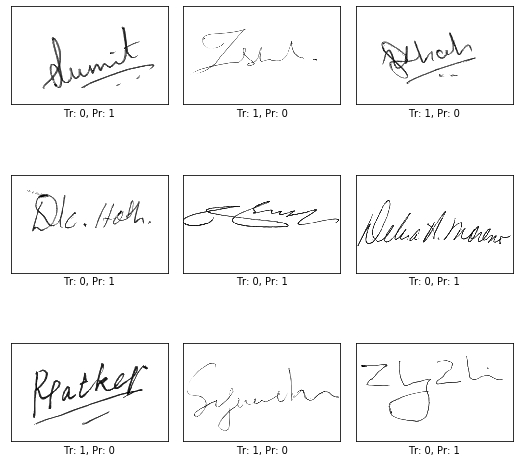

In [ ]:
# Get the true classes for those images.
cls_true = Res_mistakes_Truth[0:9]

cls_pred = Res_mistakes_pred[0:9]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)  

IndexError: ignored

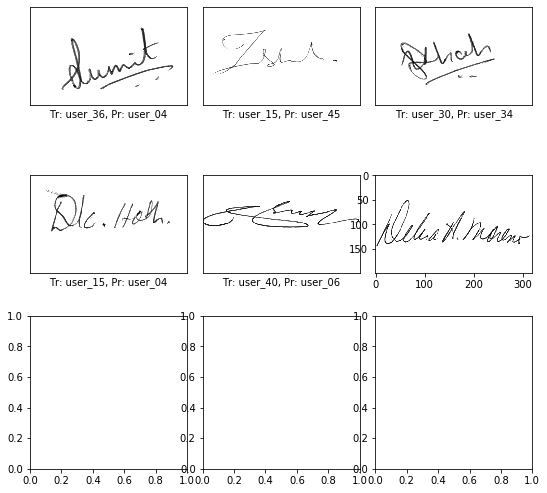

In [ ]:
# Get the true classes for those images.
cls_true = User_mistakes_Truth[0:5]

cls_pred = User_mistakes_pred[0:5]

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true, cls_pred=cls_pred)  